## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This quantum hybrid approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions, specifically a GHZ state.

This implementation uses aer_simulator_statevector.

## Implementation (statevector simulation)

In [1]:
# Create enviroment with conda
#conda create -n myenv python=3.10
# IMPORTANT: Make sure you are on 3.10
%pip install qiskit==1.4.2 qiskit-ibm-runtime qiskit-aer qiskit-machine-learning 'qiskit-machine-learning[sparse]' qiskit-algorithms
%pip install tensorflow
%pip install matplotlib
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, RealAmplitudes, ZZFeatureMap, EfficientSU2
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import SamplerQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram
from qiskit_algorithms.gradients import ParamShiftSamplerGradient

import numpy as np
import tensorflow as tf
import copy
import matplotlib.pyplot as plt
import time
import os

2025-06-10 00:29:52.114735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749508192.152547  144132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749508192.159922  144132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749508192.181344  144132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749508192.181371  144132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749508192.181375  144132 computation_placer.cc:177] computation placer alr

In [3]:
# Get backend
backend = Aer.get_backend('aer_simulator_statevector')

In [4]:
# Number of qubits
REAL_DIST_NQUBITS = 4

draw_circuits = 0
draw_prob = 0
draw_images = 1

In [5]:
# Create real data cirdcuit
def generate_ghz(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
 
    l = int(np.ceil(np.log2(num_qubits)))
    for m in range(l, 0, -1):
        for k in range(0, num_qubits, 2 ** m):
            if k + 2 ** (m - 1) >= num_qubits: continue
            qc.cx(k, k + 2 ** (m - 1))
    return qc

real_circuit = generate_ghz(REAL_DIST_NQUBITS)

if draw_circuits:
    real_circuit.draw('mpl')

In [6]:
# Suppose X is your real data matrix with shape (num_samples, num_features)
X = np.array([
    [
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ], 
    [
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ]
    ])

# Rescale to [0, π] (important for trigonometric rotation gates)
X_scaled = np.pi * X / np.max(X)

# Define the feature map
feature_map = ZZFeatureMap(feature_dimension=len(X[0].flatten()), reps=1)

# For each sample, bind values into the circuit
from qiskit import transpile

encoded_circuits = []
for x in X_scaled:
    x = x.flatten()
    bound_circuit = feature_map.assign_parameters(x)
    encoded_circuits.append(bound_circuit.decompose())
if draw_circuits:   
    encoded_circuits[0].draw('mpl')


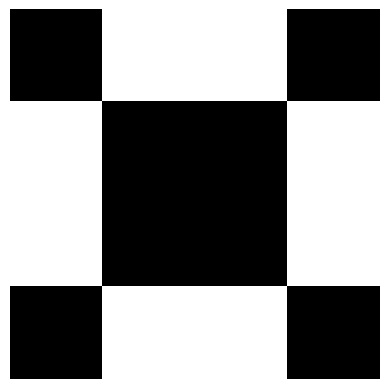

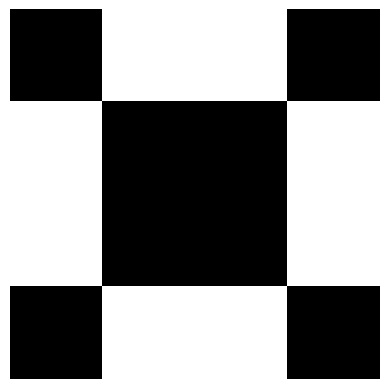

In [7]:
# Create real data sample circuit
def generate_real_circuit(matrix):
    vec = matrix.flatten()
    normed = vec / np.linalg.norm(vec)

    sv = Statevector(normed)
    if not sv.is_valid(): raise Exception("Invalid statevector")

    qc = QuantumCircuit(REAL_DIST_NQUBITS)
    qc.initialize(normed, qc.qubits)
    return qc, sv
    

X = np.array([
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 1, 1, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0.5, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0.5, 0, 1],
        [1, 0, 0.5, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0.5, 0, 1],
        [1, 0, 0.5, 0.5, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0.5, 0.5, 0, 1],
        [1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1],
        [1, 0, 0.5, 0.5, 0.5, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 1, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 1, 1],
        [1, 1, 1, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ], 
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ]
    ])

#matrix = X[0]

X = np.array([
    [
        [0, 1, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ], 
    [
        [1, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 0]
    ]
    ])

matrix = X[0]

real_circuit, real_prob_sv = generate_real_circuit(matrix)

if draw_images:
    plt.imshow(matrix, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()
    
    real_prob_list = real_prob_sv.probabilities()
    real_prob_matr = np.array(real_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(real_prob_matr, cmap='gray', vmin=np.min(real_prob_list), vmax=np.max(real_prob_list))
    plt.axis('off')
    plt.show()

In [8]:
# Create generator

# generator = TwoLocal(REAL_DIST_NQUBITS,
#                      # Parameterized single qubit rotations
#                      ['ry', 'rz'],
#                      'cz',  # Entangling gate
#                      'full', # Entanglement structure: all to all
#                      reps=2, # Number of layers
#                      parameter_prefix='θ_g',
#                      name='Generator')

generator = RealAmplitudes(REAL_DIST_NQUBITS,
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates

if draw_circuits:
    generator.draw('mpl')

In [9]:
# Create discriminator
def generate_discriminator(num_qubits, disc_weights, measure):
    qc = QuantumCircuit(num_qubits, 1, name="Discriminator")
    param_index = 0

    qc.barrier()

    #for?
    # qc.h(0)

    for q in range(num_qubits):
        qc.h(q)
        qc.rx(disc_weights[param_index], q); param_index += 1
        qc.ry(disc_weights[param_index], q); param_index += 1
        qc.rz(disc_weights[param_index], q); param_index += 1

    # for i in range(num_qubits - 1):
    #     qc.cx(i, i + 1)
    for i in range(num_qubits - 1):
        qc.cx(i, num_qubits - 1)
    # l = int(np.ceil(np.log2(num_qubits)))
    # for m in range(1, l+1):
    #     print("m:", m)
    #     for k in range(1, num_qubits, 2 ** m):
    #         print("k:", k)
    #         if k + 2 ** (m - 1) >= num_qubits: continue
    #         qc.cx(k, k + 2 ** (m - 1))

    qc.rx(disc_weights[param_index], num_qubits-1); param_index += 1
    qc.ry(disc_weights[param_index], num_qubits-1); param_index += 1
    qc.rz(disc_weights[param_index], num_qubits-1); param_index += 1
    
    if measure:
        qc.measure(num_qubits-1, 0) # For real hardware execution
    return qc
disc_weights = ParameterVector('θ_d', 3*(REAL_DIST_NQUBITS+1))
discriminator = generate_discriminator(REAL_DIST_NQUBITS, disc_weights, 0)
discriminator_meas = generate_discriminator(REAL_DIST_NQUBITS, disc_weights, 1)

if draw_circuits:
    discriminator.draw('mpl')
    

In [10]:
# Parameters
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters
N_GPARAMS, N_DPARAMS

(12, 15)

In [11]:
# Connect real data and discriminator
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)

real_disc_circuit_meas = QuantumCircuit(REAL_DIST_NQUBITS)
real_disc_circuit_meas.compose(real_circuit, inplace=True)
real_disc_circuit_meas.compose(discriminator_meas, inplace=True)

In [12]:
# Connect generator and discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)

gen_disc_circuit_meas = QuantumCircuit(REAL_DIST_NQUBITS)
gen_disc_circuit_meas.compose(generator, inplace=True)
gen_disc_circuit_meas.compose(discriminator_meas, inplace=True)

In [13]:
# Cost calculation functions

def generator_cost(gen_params):
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    prob_fake_true = Statevector(gen_disc_circuit
                              .assign_parameters(curr_params)
                             ).probabilities([REAL_DIST_NQUBITS-1])[1] # Get total prob of measuring |1> on last qubit
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    prob_fake_true = Statevector(gen_disc_circuit
                                .assign_parameters(curr_params)
                               ).probabilities([REAL_DIST_NQUBITS-1])[1]
    prob_real_true = Statevector(real_disc_circuit.
                                 assign_parameters(disc_params.numpy())
                                ).probabilities([REAL_DIST_NQUBITS-1])[1]
    cost = prob_fake_true - prob_real_true
    return cost

In [14]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions

def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [15]:
# Use SamplerQNN to compile the parameterized circuit and handle calculation of the gradient recipes.

sampler = Sampler(mode=backend)

gradient = ParamShiftSamplerGradient(sampler=sampler)

# specify QNN to update generator weights
gen_qnn = SamplerQNN(circuit=gen_disc_circuit_meas,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     input_params=gen_disc_circuit.parameters[:N_DPARAMS],
                     # differentiable weights (generator weights)
                     weight_params=gen_disc_circuit.parameters[N_DPARAMS:],
                     sparse=True, # returns sparse probability vector
                     sampler=sampler,
                     #gradient=gradient
                     )

# specify QNNs to update discriminator weights regarding to fake data
disc_fake_qnn = SamplerQNN(circuit=gen_disc_circuit_meas, # parameterized circuit
                           # frozen input arguments (generator weights)
                           input_params=gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           sampler=sampler,
                           #gradient=gradient
                           )

# # specify QNNs to update discriminator weights regarding to real data
disc_real_qnn = SamplerQNN(circuit=real_disc_circuit_meas, # parameterized circuit
                           input_params=[], # no input parameters
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           sampler=sampler,
                           #gradient=gradient
                           )

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [16]:
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))

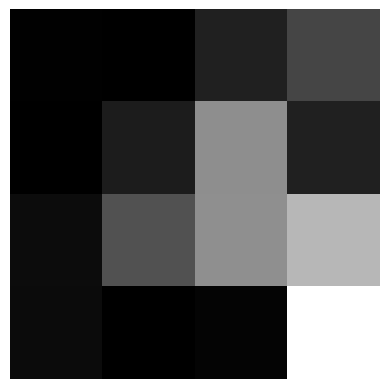

In [17]:
# Display initial generator distribution
init_gen_circuit = generator.assign_parameters(init_gen_params)
init_prob_sv = Statevector(init_gen_circuit)

if draw_prob:
    init_prob_dict = init_prob_sv.probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial generator distribution")
    plot_histogram(init_prob_dict, ax=ax1)

if draw_images:
    init_prob_list = init_prob_sv.probabilities()
    init_prob_matr = np.array(init_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(init_prob_matr, cmap='gray', vmin=np.min(init_prob_list), vmax=np.max(init_prob_list))
    plt.axis('off')
    plt.show()


In [18]:
# Initialize Adam optimizer from Keras (TensorFlow)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

2025-06-10 00:29:57.644944: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
def initialize_parameters(reset, data_folder_name="data", training_data_file_name='training_data', parameter_data_file_name='parameters'):
    data_folder_name += '/'
    if not os.path.exists(data_folder_name):
        os.mkdir(data_folder_name) # Create data folder

    training_data_file = data_folder_name + training_data_file_name + '_q' + str(REAL_DIST_NQUBITS) + '.txt'
    parameter_data_file = data_folder_name + parameter_data_file_name + '_q' + str(REAL_DIST_NQUBITS) + '.txt'

    if reset == 1:
        current_epoch = 0
        gloss, dloss, kl_div = [], [], []

        gen_params = tf.Variable(init_gen_params)
        disc_params = tf.Variable(init_disc_params)
        best_gen_params = tf.Variable(init_gen_params)

        file = open(training_data_file,'w')

    else:
        with open(training_data_file) as f: # Load training data
            lines = f.read().splitlines()
        current_epoch = len(lines)
        gloss, dloss, kl_div = [], [], []
        for line in lines:
            line_data = line.split(";")
            if len(line_data) != 4:
                print("Error in training_data.txt file in line:", line)
            gloss.append(np.float64(line_data[1]))
            dloss.append(np.float64(line_data[2]))
            kl_div.append(np.float64(line_data[3]))

        with open(parameter_data_file) as f: # Load parameters
            line = f.readline()
        line_data = line.split(";")
        if len(line_data) != 3:
            print("Error in parameters.txt file")
        gen_params = tf.Variable(np.array(eval(line_data[0])).astype(float))
        disc_params = tf.Variable(np.array(eval(line_data[1])).astype(float))
        best_gen_params = tf.Variable(np.array(eval(line_data[2])).astype(float))

        file = open(training_data_file,'a')

    return current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file, parameter_data_file

In [21]:
# Training

#--- Initialize parameters ---#
max_epoch = 100
reset = 1 # Reset data

current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file, parameter_data_file = initialize_parameters(reset)


#--- Initialize optimizers with loaded parameters ---#
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    

TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
print(TABLE_HEADERS)
start_time = time.time()

#--- Training loop ---#
try: # In case of interruption
    for epoch in range(current_epoch, max_epoch):

        #--- Quantum discriminator parameter updates ---#
        D_STEPS = 5 # N discriminator updates per generator update
        for disc_train_step in range(D_STEPS):
            d_fake = disc_fake_qnn.backward(gen_params, disc_params)[1].todense()[0, 1] #Backwards returns [n_batch, n_qubits, n_params] shape

            d_real = disc_real_qnn.backward([], disc_params)[1].todense()[0, 1]

            grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
            grad_dcost = tf.convert_to_tensor(grad_dcost)
            
            discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                        [disc_params]))
            
            if disc_train_step % D_STEPS == 0:
                dloss.append(discriminator_cost(disc_params))

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(1):
            grads = gen_qnn.backward(disc_params, gen_params)[1].todense()[0][0]

            grads = tf.convert_to_tensor(grads)

            generator_optimizer.apply_gradients(zip([grads], [gen_params]))
            gloss.append(generator_cost(gen_params))

        #--- Track KL and save best performing generator weights ---#
        gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy()) # Create test circuit with updated gen parameters
        gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict() # Retrieve probability distribution of current generator
        
        real_prob_dict = Statevector(real_circuit).probabilities_dict() # Constant real probability distribution
        
        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            best_gen_params = copy.deepcopy(gen_params) # New best

        #--- Save progress in file ---#
        file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

        if epoch % 10 == 0: # Print progress
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
            
#--- Save data in file ---#
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
    file.close()
    
print("Training complete.")


Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |
    0 |         -0.551 |              0.163 |     2.5 |          2.5 | 6.51 |
   10 |         -0.344 |             -0.538 |    2.22 |         2.22 | 10.7 |
   20 |          -0.37 |             -0.526 |    2.01 |         1.98 | 10.6 |
   30 |         -0.349 |             -0.556 |    2.44 |         1.98 | 10.8 |


KeyboardInterrupt: 

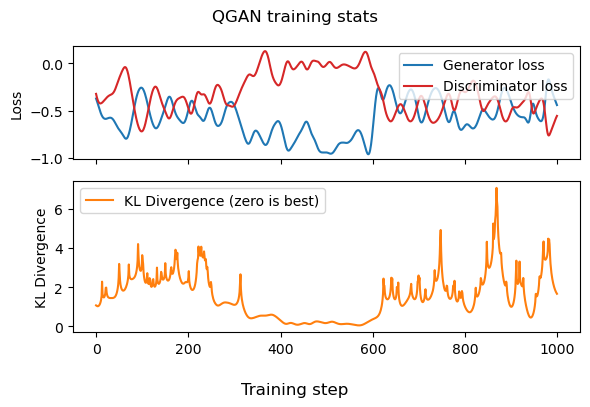

In [104]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)",
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout()

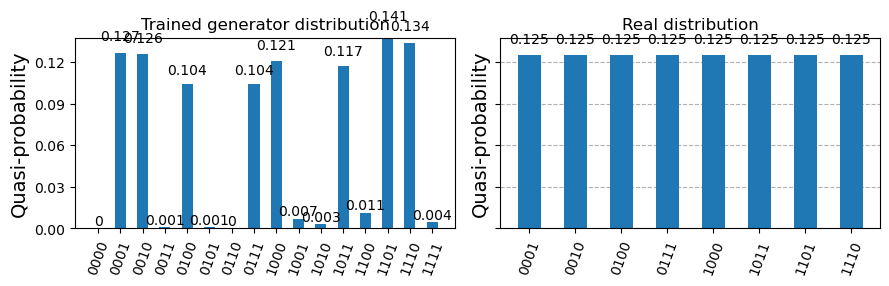

In [110]:
# Create test circuit with new parameters
draw_prob = 1
if draw_prob:
    gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
    gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
    #fig, ax1 = plt.subplots(1, 1, sharey=True)
    plot_histogram(gen_prob_dict, ax=ax1)
    ax1.set_title("Trained generator distribution")
    plot_histogram(real_prob_dict, ax=ax2)
    ax2.set_title("Real distribution")
    fig.tight_layout()

draw_images = 0
if draw_images:
    gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
    gen_prob_sv = Statevector(gen_checkpoint_circuit)
    gen_prob_list = gen_prob_sv.probabilities()
    gen_prob_matr = np.array(gen_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(gen_prob_matr, cmap='gray', vmin=np.min(gen_prob_list), vmax=np.max(gen_prob_list))
    plt.axis('off')
    plt.show()

    real_prob_list = real_prob_sv.probabilities()
    real_prob_matr = np.array(real_prob_list).reshape((2**int(REAL_DIST_NQUBITS/2), 2**int(REAL_DIST_NQUBITS/2)))
    plt.imshow(real_prob_matr, cmap='gray', vmin=np.min(real_prob_list), vmax=np.max(real_prob_list))
    plt.axis('off')
    plt.show()